In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [31]:
accounts = pd.read_csv("archive/ravenstack_accounts.csv")
feature_usage = pd.read_csv("archive/ravenstack_feature_usage.csv")

In [32]:
feature_usage.head()

,usage_id,subscription_id,usage_date,feature_name,usage_count,usage_duration_secs,error_count,is_beta_feature
0,U-1c6c24,S-0fcf7d,2023-07-27,feature_20,9,5004,0,False
1,U-f07cb8,S-c25263,2023-08-07,feature_5,9,369,0,False
2,U-096807,S-f29e7f,2023-12-07,feature_3,9,1458,0,False
3,U-6b1580,S-be655e,2024-07-28,feature_40,5,2085,0,False
4,U-720a29,S-f9b1d0,2024-12-02,feature_12,12,900,0,False


FEATURE USAGE ANALYSIS

Total records after merge: 25000

AVAILABLE FEATURES:
  1. feature_20: 643 usage records
  2. feature_5: 577 usage records
  3. feature_3: 598 usage records
  4. feature_40: 621 usage records
  5. feature_12: 659 usage records
  6. feature_14: 600 usage records
  7. feature_34: 650 usage records
  8. feature_27: 611 usage records
  9. feature_18: 588 usage records
  10. feature_28: 623 usage records
  11. feature_36: 648 usage records
  12. feature_35: 587 usage records
  13. feature_25: 615 usage records
  14. feature_4: 625 usage records
  15. feature_24: 643 usage records
  16. feature_37: 636 usage records
  17. feature_7: 619 usage records
  18. feature_15: 640 usage records
  19. feature_30: 629 usage records
  20. feature_39: 631 usage records
  21. feature_19: 589 usage records
  22. feature_6: 655 usage records
  23. feature_21: 591 usage records
  24. feature_1: 629 usage records
  25. feature_22: 636 usage records
  26. feature_38: 643 usage records
 

/var/folders/zv/v1v0t9595750wr726xp00nl80000gn/T/ipykernel_1938/1959317342.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(
/var/folders/zv/v1v0t9595750wr726xp00nl80000gn/T/ipykernel_1938/1959317342.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(
/var/folders/zv/v1v0t9595750wr726xp00nl80000gn/T/ipykernel_1938/1959317342.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(


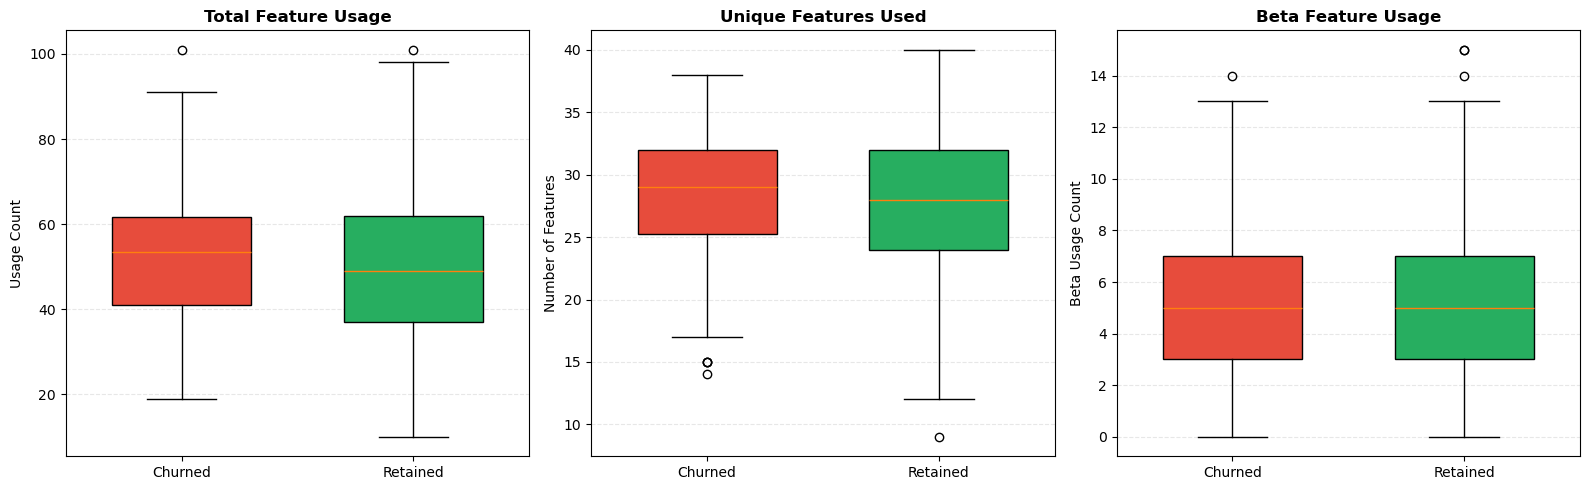

In [33]:
print("FEATURE USAGE ANALYSIS")
print("")

feature_with_account = feature_usage.merge(
    subscriptions[['subscription_id', 'account_id']], 
    on='subscription_id',
    how='left'
).dropna(subset=['account_id'])

print(f"Total records after merge: {len(feature_with_account)}")
print("")

print("AVAILABLE FEATURES:")
features = feature_with_account['feature_name'].unique()
for i, feature in enumerate(features, 1):
    count = (feature_with_account['feature_name'] == feature).sum()
    print(f"  {i}. {feature}: {count:,} usage records")
print("")

beta_count = feature_with_account['is_beta_feature'].sum()
print(f"Beta feature usage: {beta_count:,} records")
print("")

customer_feature_stats = feature_with_account.groupby('account_id').agg({
    'usage_id': 'count',
    'feature_name': 'nunique',
    'is_beta_feature': 'sum'
}).rename(columns={
    'usage_id': 'total_usage_count',
    'feature_name': 'unique_features_used',
    'is_beta_feature': 'beta_feature_count'
})

customer_analysis = accounts[['account_id', 'churn_flag']].merge(
    customer_feature_stats, 
    on='account_id', 
    how='left'
).fillna(0)

print(f"Customers analyzed: {len(customer_analysis)}")
print(f"  With feature usage: {(customer_analysis['total_usage_count'] > 0).sum()}")
print(f"  Without feature usage: {(customer_analysis['total_usage_count'] == 0).sum()}")
print("")

churned_customers = customer_analysis[customer_analysis['churn_flag'] == True]
retained_customers = customer_analysis[customer_analysis['churn_flag'] == False]

print("CHURNED vs RETAINED COMPARISON")
print("")

avg_usage_churned = churned_customers['total_usage_count'].mean()
avg_usage_retained = retained_customers['total_usage_count'].mean()

print(f"TOTAL USAGE:")
print(f"  Churned:  {avg_usage_churned:.1f} usage/customer")
print(f"  Retained: {avg_usage_retained:.1f} usage/customer")
print(f"  Difference: {avg_usage_retained - avg_usage_churned:+.1f}")
print("")

avg_unique_churned = churned_customers['unique_features_used'].mean()
avg_unique_retained = retained_customers['unique_features_used'].mean()

print(f"UNIQUE FEATURES:")
print(f"  Churned:  {avg_unique_churned:.1f} features/customer")
print(f"  Retained: {avg_unique_retained:.1f} features/customer")
print(f"  Difference: {avg_unique_retained - avg_unique_churned:+.1f}")
print("")

avg_beta_churned = churned_customers['beta_feature_count'].mean()
avg_beta_retained = retained_customers['beta_feature_count'].mean()

print(f"BETA FEATURE USAGE:")
print(f"  Churned:  {avg_beta_churned:.1f} beta usage/customer")
print(f"  Retained: {avg_beta_retained:.1f} beta usage/customer")
print(f"  Difference: {avg_beta_retained - avg_beta_churned:+.1f}")
print("")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

bp1 = axes[0].boxplot(
    [churned_customers['total_usage_count'], retained_customers['total_usage_count']],
    labels=['Churned', 'Retained'],
    patch_artist=True,
    widths=0.6
)
bp1['boxes'][0].set_facecolor('#e74c3c')
bp1['boxes'][1].set_facecolor('#27ae60')
axes[0].set_title('Total Feature Usage', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Usage Count', fontsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

bp2 = axes[1].boxplot(
    [churned_customers['unique_features_used'], retained_customers['unique_features_used']],
    labels=['Churned', 'Retained'],
    patch_artist=True,
    widths=0.6
)
bp2['boxes'][0].set_facecolor('#e74c3c')
bp2['boxes'][1].set_facecolor('#27ae60')
axes[1].set_title('Unique Features Used', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Features', fontsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

bp3 = axes[2].boxplot(
    [churned_customers['beta_feature_count'], retained_customers['beta_feature_count']],
    labels=['Churned', 'Retained'],
    patch_artist=True,
    widths=0.6
)
bp3['boxes'][0].set_facecolor('#e74c3c')
bp3['boxes'][1].set_facecolor('#27ae60')
axes[2].set_title('Beta Feature Usage', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Beta Usage Count', fontsize=10)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [34]:
print("DEEPER FEATURE USAGE ANALYSIS")
print("")

customer_analysis['usage_per_feature'] = customer_analysis.apply(
    lambda row: row['total_usage_count'] / row['unique_features_used'] 
    if row['unique_features_used'] > 0 else 0, 
    axis=1
)

churned_customers = customer_analysis[customer_analysis['churn_flag'] == True]
retained_customers = customer_analysis[customer_analysis['churn_flag'] == False]

churned_intensity = churned_customers['usage_per_feature'].mean()
retained_intensity = retained_customers['usage_per_feature'].mean()

print("USAGE INTENSITY (usage per feature):")
print(f"  Churned:  {churned_intensity:.1f} usage/feature")
print(f"  Retained: {retained_intensity:.1f} usage/feature")
print(f"  Difference: {retained_intensity - churned_intensity:+.1f}")
print("")

if churned_intensity > retained_intensity * 1.3:
    print("INSIGHT: Churned customers use features more intensively")
    print("  -> Possible frustration: trying hard but not getting value")
elif churned_intensity < retained_intensity * 0.7:
    print("INSIGHT: Churned customers use features less intensively")
    print("  -> Shallow engagement")
else:
    print("INSIGHT: Similar usage intensity")
print("")

print("FEATURE USAGE DISTRIBUTION:")
print("")

no_usage_churned = (churned_customers['total_usage_count'] == 0).sum()
no_usage_retained = (retained_customers['total_usage_count'] == 0).sum()

print(f"ZERO USAGE:")
print(f"  Churned:  {no_usage_churned} ({no_usage_churned/len(churned_customers)*100:.1f}%)")
print(f"  Retained: {no_usage_retained} ({no_usage_retained/len(retained_customers)*100:.1f}%)")
print("")

high_usage_threshold = customer_analysis['total_usage_count'].quantile(0.75)
high_usage_churned = (churned_customers['total_usage_count'] >= high_usage_threshold).sum()
high_usage_retained = (retained_customers['total_usage_count'] >= high_usage_threshold).sum()

print(f"HIGH USAGE (top 25%):")
print(f"  Churned:  {high_usage_churned} ({high_usage_churned/len(churned_customers)*100:.1f}%)")
print(f"  Retained: {high_usage_retained} ({high_usage_retained/len(retained_customers)*100:.1f}%)")
print("")


print("FEATURE-SPECIFIC CHURN RATE")

print("")

feature_churn_analysis = feature_with_account.merge(
    accounts[['account_id', 'churn_flag']], 
    on='account_id'
)

feature_usage_by_churn = feature_churn_analysis.groupby(['feature_name', 'churn_flag']).size().unstack(fill_value=0)
feature_usage_by_churn.columns = ['Retained', 'Churned']
feature_usage_by_churn['Churn_Rate'] = (
    feature_usage_by_churn['Churned'] / 
    (feature_usage_by_churn['Churned'] + feature_usage_by_churn['Retained']) * 100
)
feature_usage_by_churn = feature_usage_by_churn.sort_values('Churn_Rate', ascending=False)

print("FEATURES BY CHURN RATE:")
print("")
for feature, row in feature_usage_by_churn.iterrows():
    total = row['Churned'] + row['Retained']
    print(f"{feature:30} | Churn: {row['Churn_Rate']:5.1f}% | Total: {total:,}")


DEEPER FEATURE USAGE ANALYSIS

USAGE INTENSITY (usage per feature):
  Churned:  1.8 usage/feature
  Retained: 1.8 usage/feature
  Difference: -0.0

INSIGHT: Similar usage intensity

FEATURE USAGE DISTRIBUTION:

ZERO USAGE:
  Churned:  0 (0.0%)
  Retained: 0 (0.0%)

HIGH USAGE (top 25%):
  Churned:  28 (25.5%)
  Retained: 101 (25.9%)

FEATURE-SPECIFIC CHURN RATE

FEATURES BY CHURN RATE:

feature_1                      | Churn:  26.6% | Total: 629.0
feature_11                     | Churn:  25.5% | Total: 643.0
feature_4                      | Churn:  25.3% | Total: 625.0
feature_15                     | Churn:  25.2% | Total: 640.0
feature_37                     | Churn:  25.0% | Total: 636.0
feature_20                     | Churn:  24.9% | Total: 643.0
feature_38                     | Churn:  24.6% | Total: 643.0
feature_9                      | Churn:  24.5% | Total: 624.0
feature_19                     | Churn:  24.3% | Total: 589.0
feature_26                     | Churn:  24.2% | Tot

KEY FINDINGS
1. USAGE VOLUME

Churned customers: 52 usage/customer
Retained customers: 49 usage/customer
Difference: +3 (churned slightly higher)

2. USAGE INTENSITY

Both groups: 1.8 usage/feature
No difference in how intensively features are used

3. FEATURE DIVERSITY

Churned: 28.3 features/customer
Retained: 27.4 features/customer
Difference: +0.9 (churned explore slightly more)

4. FEATURE-SPECIFIC CHURN

Range: 19.0% - 26.6%
Difference: 7.6 percentage points
All features show similar churn rates


CONCLUSION
Feature usage does NOT significantly impact retention.
IMPLICATIONS
1. Product engagement is NOT the issue

Customers are using features
Usage patterns are similar

2. Problem likely elsewhere:

Product VALUE (not solving real problems)
PRICING (too expensive for value received)
CUSTOMER SUCCESS (not helping customers succeed)
COMPETITION (better alternatives available)

3. Time series finding supports this:

Churn rate increasing 2024: 8% → 23%
While feature usage remains constant
Suggests systemic product/market fit issue


RECOMMENDATIONS

Conduct customer interviews (why leaving?)
Review pricing vs value delivered
Analyze competitor offerings
Improve customer success onboarding
Focus on DevTools segment (highest churn: 31%)